In [1]:
#downloading the dataset


!gdown --id 173oVgHFBj3lgvKuGajcxK59agJYR8vjj
from zipfile import ZipFile
with ZipFile('HardHat_Dataset.zip','r') as zip:
  zip.extractall()



Downloading...
From: https://drive.google.com/uc?id=173oVgHFBj3lgvKuGajcxK59agJYR8vjj
To: /content/HardHat_Dataset.zip
1.25GB [00:23, 53.6MB/s]


In [1]:
import os
import xml.etree.ElementTree as ET

#function to convert xml annotations into array format
def convert_annotations(path):
  annotations=[]
  for directory_path, directory_names, files in os.walk(path):
    for f in files:
      if f.endswith('.xml'):
        path = os.path.join(directory_path,f)
        tree = ET.parse(path)
        root = tree.getroot()
        anno = []
        pth = os.path.join('images',root.find('filename').text)
        anno.append(pth)
      
        anno.append(int(root.find('size/height').text))
        anno.append(int(root.find('size/width').text))

        for obj in root.iter('object'):
          box = obj.find('bndbox')
          b=[]
          b.append(int(box.find('xmin').text))
          b.append(int(box.find('ymin').text))
          b.append(int(box.find('xmax').text))
          b.append(int(box.find('ymax').text))
          anno.append(b)
      annotations.append(anno)
  return annotations

annotations = convert_annotations('annotations')

In [2]:
images = []
labels = []

for anno in annotations:
  images.append(anno[0])
  labels.append(anno[3:])


In [3]:
len(images)

4750

In [4]:
#prepare the image data and label matrix 

import cv2
import numpy as np

def read(img_path,labels):

  img = cv2.imread(img_path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(416,416))
  img_h , img_w = img.shape[0:2]
  img = img/255.
  

  label = np.zeros([7,7,10])
  
  for obj in labels:
    xmin = obj[0]
    ymin = obj[1]
    xmax = obj[2]
    ymax = obj[3]
    x = (xmin+xmax)/2 /img_w
    y = (ymin+ymax)/2 / img_h
    w = (xmax - xmin) / img_w
    h = (ymax - ymin) / img_h

    loc = [7*x,7*y]
    loc_i = int(loc[1])
    loc_j = int(loc[0])
    y = loc[1] - loc_i
    x = loc[0] - loc_j

    if label[loc_i,loc_j,0]==0:
      label[loc_i,loc_j,0]=1
      label[loc_i,loc_j,1]=1
      label[loc_i,loc_j,2:6] = [x,y,7*w,7*h]
      label[loc_i,loc_j,6:10] = [x,y,7*w,7*h]
      #label[loc_i,loc_j,2:6] = [ymin/416,ymax/416,xmin/416,xmax/416]
  return img,label

In [5]:
#custom generator since preparing all data in notebook exceeds ram
from tensorflow import keras

class data_generator(keras.utils.Sequence):
  def __init__(self,images,labels,batch_size):
    super().__init__()
    self.images = images
    self.labels = labels
    self.batch_size = batch_size

  def __len__(self):
    return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)

  def __getitem__(self,idx):
    x = self.images[idx*self.batch_size:min((idx+1)*batch_size,len(self.images))]
    y = self.labels[idx*self.batch_size:min((idx+1)*batch_size,len(self.images))]

    train_image = []
    train_label = []

    for i in range(0, len(x)):
      image , label = read(x[i],y[i])
      train_image.append(image)
      train_label.append(label)
    return np.array(train_image), np.array(train_label)  



In [6]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images,labels, test_size=0.2)

In [7]:
batch_size = 16

train_generator = data_generator(x_train,y_train,batch_size)

val_generator = data_generator(x_val,y_val,batch_size)

x_, y_ = train_generator.__getitem__(0)
x_v, y_v = train_generator.__getitem__(0)
print(x_.shape)
print(y_.shape)

print(x_v.shape)
print(y_v.shape)

(16, 416, 416, 3)
(16, 7, 7, 10)
(16, 416, 416, 3)
(16, 7, 7, 10)


In [8]:

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.models import Sequential

basemodel = ResNet50V2(include_top=False,weights = 'imagenet',input_shape=(416,416,3))
basemodel.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 422, 422, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 208, 208, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 210, 210, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2

model = Sequential(basemodel)
model.add(Dropout(0.5))
model.add(Conv2D(1024,(1,1),strides=(1,1),padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(0.01))

model.add(Conv2D(1024,(5,5),(1,1)))
model.add(BatchNormalization())
model.add(LeakyReLU(0.01))
model.add(Dropout(0.4))

model.add(Conv2D(1024,(3,3),(1,1)))
model.add(BatchNormalization())
model.add(LeakyReLU(0.01))
model.add(Dropout(0.5))

model.add(Conv2D(512,(1,1),(1,1)))
model.add(BatchNormalization())
model.add(LeakyReLU(0.01))
model.add(Dropout(0.2))

model.add(Conv2D(10,(1,1),(1,1)))
model.add(Activation('sigmoid'))
#model.add(Flatten())
#model.add(Dense(490, activation='sigmoid'))
#model.add(Reshape(target_shape=(7,7,10)))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 13, 13, 2048)      23564800  
_________________________________________________________________
dropout_14 (Dropout)         (None, 13, 13, 2048)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 13, 13, 1024)      2098176   
_________________________________________________________________
batch_normalization_17 (Batc (None, 13, 13, 1024)      4096      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 13, 13, 1024)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 9, 9, 1024)        26215424  
_________________________________________________________________
batch_normalization_18 (Batc (None, 9, 9, 1024)       

In [34]:
import keras.backend as K


def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims 
    box_wh = feats[..., 2:4] / conv_dims
    return box_xy, box_wh


def yolo_loss(y_true, y_pred):
    
    label_box = y_true[..., 2:6]  # ? * 7 * 7 * 4
    response_mask = y_true[...,0]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1

    
    predict_trust = y_pred[..., 0:2]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 2:10]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

    # Determine confidence weights from object and no_object weights.
    # NOTE: YOLO does not use binary cross-entropy here.
    no_object_loss = 1 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    

    # Coordinate loss for matching detection boxes.
    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 1 * box_mask * response_mask * K.square((label_xy - predict_xy))
    box_loss += 1 * box_mask * response_mask * K.square((label_wh - predict_wh))
    box_loss = K.sum(box_loss)

    loss = confidence_loss + box_loss

    return loss

In [35]:
# defining a function to save the weights of best model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.1,mode='auto',verbose=1)

mcp_save = ModelCheckpoint('/content/drive/MyDrive/weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [36]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.005)

model.compile(loss=yolo_loss ,optimizer=adam)

hist = model.fit(x=train_generator,
          steps_per_epoch = int(len(x_train) // batch_size),
          epochs = 20,
          verbose = 1,
          validation_data = val_generator,
          workers= 4,
          callbacks=[mcp_save,reduce_lr]
          )

Epoch 1/20
237/237 [==============================] - 170s 690ms/step - loss: 59.6799 - val_loss: 53.7666


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
237/237 [==============================] - 162s 681ms/step - loss: 54.6942 - val_loss: 58.8215
Epoch 3/20
237/237 [==============================] - 161s 679ms/step - loss: 53.1857 - val_loss: 52.8356
Epoch 4/20
237/237 [==============================] - 162s 681ms/step - loss: 55.3147 - val_loss: 59.7689
Epoch 5/20
237/237 [==============================] - 161s 679ms/step - loss: 54.9627 - val_loss: 58.5927
Epoch 6/20
237/237 [==============================] - 162s 680ms/step - loss: 55.9517 - val_loss: 52.4864
Epoch 7/20
237/237 [==============================] - 162s 680ms/step - loss: 52.7076 - val_loss: 51.0742
Epoch 8/20
237/237 [==============================] - 162s 681ms/step - loss: 50.9550 - val_loss: 49.1563
Epoch 9/20
237/237 [==============================] - 162s 680ms/step - loss: 49.1931 - val_loss: 52.6336
Epoch 10/20
237/237 [==============================] - 161s 678ms/step - loss: 47.4404 - val_loss: 46.1878
Epoch 11/20
237/237 [========================

In [40]:
hist = model.fit(x=train_generator,
          steps_per_epoch = int(len(x_train) // batch_size),
          epochs = 20,
          verbose = 1,
          validation_data = val_generator,
          workers= 4,
          callbacks=[mcp_save,reduce_lr]
          )

Epoch 1/20
237/237 [==============================] - 162s 682ms/step - loss: 38.7312 - val_loss: 42.3208
Epoch 2/20
237/237 [==============================] - 162s 680ms/step - loss: 38.0787 - val_loss: 41.3974


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/20
237/237 [==============================] - 162s 682ms/step - loss: 37.6296 - val_loss: 41.1680
Epoch 4/20
237/237 [==============================] - 162s 682ms/step - loss: 36.8409 - val_loss: 41.5273
Epoch 5/20
237/237 [==============================] - 162s 681ms/step - loss: 36.5669 - val_loss: 41.7165
Epoch 6/20
237/237 [==============================] - 162s 680ms/step - loss: 34.3130 - val_loss: 39.8459
Epoch 7/20
237/237 [==============================] - 162s 683ms/step - loss: 32.1806 - val_loss: 39.6461
Epoch 8/20
237/237 [==============================] - 162s 682ms/step - loss: 32.7011 - val_loss: 40.2473
Epoch 9/20
237/237 [==============================] - 162s 681ms/step - loss: 33.7051 - val_loss: 43.0629
Epoch 10/20
237/237 [==============================] - 162s 681ms/step - loss: 35.6301 - val_loss: 43.1211

Epoch 00010: ReduceLROnPlateau reducing learning rate to 4.9999996554106475e-05.
Epoch 11/20
237/237 [==============================] - 162s 681ms/ste

In [59]:
#loading the saved model
model.load_weights('weights.hdf5')

In [60]:
#function to predict the hats given the path of image

import cv2
import matplotlib.pyplot as plt


def predict(path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(416,416))
  img_h , img_w = img.shape[0:2]
  img = img/255.
  img = K.expand_dims(img,0)
  output = model.predict(img)
  #print(output[0,:,:,1])
  #print(output[0,:,:,0])
  predict_box = K.reshape(output[...,2:10],[-1,7,7,2,4])
  box_xy, box_wh = yolo_head(predict_box)
  xy_min , xy_max = xywh2minmax(box_xy,box_wh)
  #print(xy_min,xy_max)
  img = np.array(img[0])
  for i in range(7):
    for j in range(7):
      if output[0,i,j,0]>0.5:
        text = '%.2f'%(output[0,i,j,0])
        xmin = np.floor(xy_min[0,i,j,0,0]*416).astype('int32')
        ymin = np.floor(xy_min[0,i,j,0,1]*416).astype('int32')
        xmax = np.floor(xy_max[0,i,j,1,0]*416).astype('int32')
        ymax = np.floor(xy_max[0,i,j,1,1]*416).astype('int32')
        img=cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,255,0),1)
        cv2.putText(img,text,(xmin,ymin-15),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,0),1)
        #print(xmin,ymin,xmax,ymax)
      elif output[0,i,j,1]>0.5:
        text = '%.2f'%(output[0,i,j,1])
        xmin = np.floor(xy_min[0,i,j,0,0]*416).astype('int32')
        ymin = np.floor(xy_min[0,i,j,0,1]*416).astype('int32')
        xmax = np.floor(xy_max[0,i,j,1,0]*416).astype('int32')
        ymax = np.floor(xy_max[0,i,j,1,1]*416).astype('int32')
        cv2.putText(img,text,(xmin,ymin-15),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,0),1)
        img=cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,255,0),1) 
        #print(xmin,ymin,xmax,ymax)
  #img = cv2.resize(img,(720,720)) 
  plt.figure(figsize=(10,10))      
  plt.imshow(img)
  
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


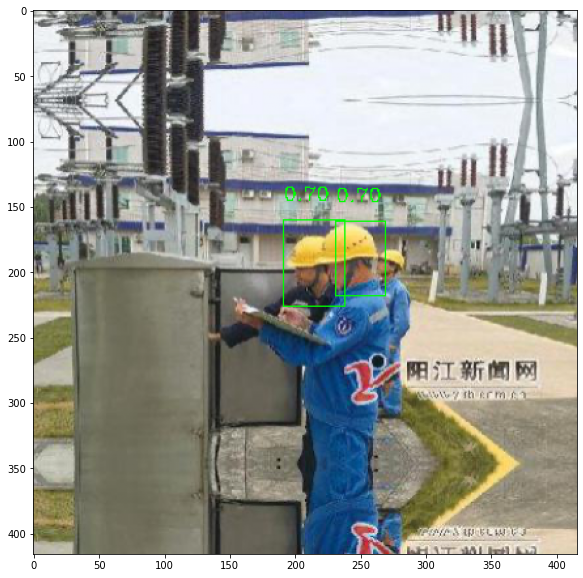

In [61]:
import matplotlib.pyplot as plt

predict('/content/hard_hat_workers889.png')

In [ ]:
while True:
  pass

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
